In [1]:
import torch, gc
import random
import copy
import itertools
import numpy as np
import utils
from trainer import LIMTrainer
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from LIM_deep_neural_classifier import LIMDeepNeuralClassifier
import dataset_equality

gc.collect()
torch.cuda.empty_cache()
utils.fix_random_seeds()

In [15]:
device = "cuda:0"
data_size = 12
embedding_dim = 4
pretrain = True
max_iter = 10
save_checkpoint_per_epoch = True

#### Train our base model that solves the factual task

In [16]:
iit_equality_dataset = \
    dataset_equality.get_IIT_equality_dataset_all(embedding_dim, 
                                                    data_size)
X_base_train, y_base_train = iit_equality_dataset[0:2]
iit_data = tuple(iit_equality_dataset[2:])

In [17]:
iit_data

([tensor([[ 1.5825e-01,  3.1859e-02,  4.6238e-01, -2.2504e-01, -2.9420e-01,
            3.2969e-01,  3.3892e-01,  7.9553e-02,  3.0692e-01,  1.0685e-01,
           -9.8202e-02, -4.5502e-01,  3.0692e-01,  1.0685e-01, -9.8202e-02,
           -4.5502e-01],
          [-3.7288e-01,  2.1115e-01, -3.7061e-01,  2.0452e-01, -3.7288e-01,
            2.1115e-01, -3.7061e-01,  2.0452e-01,  1.9447e-01, -4.4568e-02,
           -4.6739e-01, -3.4316e-01,  1.9447e-01, -4.4568e-02, -4.6739e-01,
           -3.4316e-01],
          [-3.0744e-01,  2.7855e-01, -4.5690e-02, -3.5345e-01, -3.0744e-01,
            2.7855e-01, -4.5690e-02, -3.5345e-01,  3.2844e-01, -4.1805e-01,
           -4.3781e-01,  3.8851e-01, -2.3747e-02, -5.3836e-02, -1.3071e-01,
            2.6256e-02],
          [-4.8138e-01,  5.4075e-02,  8.6173e-02, -3.9849e-01,  2.6298e-01,
            1.5155e-01, -3.7443e-01,  6.8246e-02, -4.1609e-01,  1.3580e-01,
           -2.9654e-01,  4.6791e-01, -1.2669e-01,  4.8531e-01,  2.8202e-01,
            3

In [30]:
LIM = LIMDeepNeuralClassifier(
    hidden_dim=embedding_dim*4, 
    hidden_activation=torch.nn.ReLU(), 
    num_layers=2,
    input_dim=embedding_dim*4,
    n_classes=2,
    device=device
)

In [ ]:
if pretrain:
    LIM_trainer = LIMTrainer(
        LIM,
        warm_start=True,
        max_iter=max_iter,
        batch_size=6400,
        n_iter_no_change=10000,
        shuffle_train=False,
        eta=0.001,
        save_checkpoint_per_epoch=save_checkpoint_per_epoch
    )
    
    _ = LIM_trainer.fit(
        X_base_train, 
        y_base_train, 
        iit_data=None,
        intervention_ids_to_coords=None
    )
    
    datasetIIT = dataset_equality.get_IIT_equality_dataset_both(embedding_dim, 1000)
    base_test, y_base_test, sources_test, y_IIT_test, intervention_ids_test = datasetIIT
    base_preds = LIM_trainer.predict(base_test, device="cpu")
    print(classification_report(y_base_test, base_preds))
    
    PATH = f"./saved_models/basemodel-best.bin"
    torch.save(LIM_trainer.model.state_dict(), PATH)

#### IIT-r training with a bad high-level model

In [7]:
results = {}

gathering experiments for all the control experiments

In [87]:
layer = 0
key = {
    "left":(),
    "right":(0)
}
results[(key["left"], key["right"])] = {}

In [88]:
if key["left"] in [0,1] and key["right"] in [0,1]:
    key_size = 2
elif key["left"] == (0,1) and key["right"] == (0,1):
    key_size = 4
elif key["left"] == (0,1) and key["right"] == ():
    key_size = 2
elif key["left"] == () and key["right"] == (0,1):
    key_size = 2
elif key["left"] == () or key["right"] == ():
    key_size = 1
else:
    key_size = 3
control = 3
id_to_coords = {
    control:[{"layer": layer, "start": 0, "end": key_size*embedding_dim}]
}
print(f"Control Experiment \n Layer: {layer}\n Key: {key} \n Key Size: {key_size}")

Control Experiment 
 Layer: 0
 Key: {'left': (), 'right': 0} 
 Key Size: 1


In [89]:
data_size = 1280000
train_datasetIIT = \
    dataset_equality.get_IIT_equality_dataset_control(key, 
                                                embedding_dim,   
                                                data_size)
X_base_train, y_base_train = train_datasetIIT[0:2]
iit_data = tuple(train_datasetIIT[2:])
test_datasetIIT = \
    dataset_equality.get_IIT_equality_dataset_control(key, 
                                                embedding_dim, 
                                                1000)
base_test, y_base_test, sources_test, y_IIT_test, intervention_ids_test = test_datasetIIT

In [90]:
for i in range(0, max_iter+1):
    LIM = LIMDeepNeuralClassifier(
        hidden_dim=embedding_dim*4, 
        hidden_activation=torch.nn.ReLU(), 
        num_layers=2,
        input_dim=embedding_dim*4,
        n_classes=2,
        device=device
    )

    LIM_trainer = LIMTrainer(
        LIM,
        warm_start=True,
        max_iter=10,
        batch_size=6400,
        n_iter_no_change=10000,
        shuffle_train=False,
        eta=0.001
    )
    PATH = f"./saved_models/basemodel-{i}.bin"
    LIM_trainer.model.load_state_dict(torch.load(PATH))
    LIM_trainer.model.set_analysis_mode(True)
    
    _ = LIM_trainer.fit(
        X_base_train, 
        y_base_train, 
        iit_data=iit_data,
        intervention_ids_to_coords=id_to_coords)
    
    base_preds = LIM_trainer.predict(
        base_test, device="cpu"
    )
    IIT_preds = LIM_trainer.iit_predict(
        base_test, sources_test, 
        intervention_ids_test, 
        id_to_coords, device="cpu"
    )
    r1 = classification_report(y_base_test, base_preds, output_dict=True)
    r2 = classification_report(y_IIT_test, IIT_preds, output_dict=True)
    results[(key["left"], key["right"])][i] = [r1, r2]

Finished epoch 10 of 10; error is 720.45063924789436

In [91]:
base_f1s = []
iit_f1s = []

for i in range(0, max_iter+1):
    reports = results[(key["left"], key["right"])][i]
    base_reports = reports[0]
    iit_reports = reports[1]
    
    base_f1 = base_reports["weighted avg"]["f1-score"]
    iit_f1 = iit_reports["weighted avg"]["f1-score"]
    
    base_f1s += [base_f1]
    iit_f1s += [iit_f1]

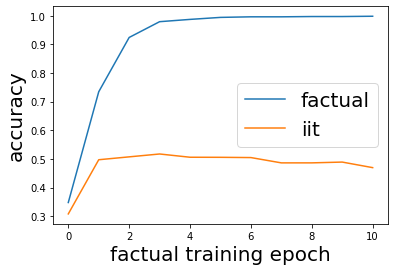

In [92]:
# Dataset
x = np.array([0,1,2,3,4,5,6,7,8,9,10])
base_f1s = np.array(base_f1s)
iit_f1s = np.array(iit_f1s)
 
# Plotting the Graph
plt.plot(x, base_f1s, label="factual")
plt.plot(x, iit_f1s, label="iit")
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("factual training epoch", fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [93]:
(key["left"], key["right"])

((), 0)

gathering results for all the non-control experiments

In [60]:
data_size = 1280000
iit_equality_dataset = \
    dataset_equality.get_IIT_equality_dataset_all(embedding_dim, 
                                                    data_size)

X_base_train, y_base_train = iit_equality_dataset[0:2]
iit_data = tuple(iit_equality_dataset[2:])

In [83]:
id_to_coords = {
    0: [{"layer": layer, "start": 0, "end": 2*embedding_dim}],
    1: [{"layer": layer, "start":  2*embedding_dim, "end": 4*embedding_dim}],
    2: [{"layer": layer, "start": 0, "end": 2*embedding_dim}, {"layer": layer, "start":  2*embedding_dim, "end": 4*embedding_dim}],
}

key = {
    "left":("full"),
    "right":("full")
}
results[(key["left"], key["right"])] = {}

datasetIIT = dataset_equality.get_IIT_equality_dataset_both(embedding_dim, 1000)

base_test, y_base_test, sources_test, y_IIT_test, intervention_ids_test = datasetIIT

In [84]:
for i in range(0, max_iter+1):
    LIM = LIMDeepNeuralClassifier(
        hidden_dim=embedding_dim*4, 
        hidden_activation=torch.nn.ReLU(), 
        num_layers=2,
        input_dim=embedding_dim*4,
        n_classes=2,
        device=device
    )

    LIM_trainer = LIMTrainer(
        LIM,
        warm_start=True,
        max_iter=10,
        batch_size=6400,
        n_iter_no_change=10000,
        shuffle_train=False,
        eta=0.001
    )
    PATH = f"./saved_models/basemodel-{i}.bin"
    LIM_trainer.model.load_state_dict(torch.load(PATH))
    LIM_trainer.model.set_analysis_mode(True)
    
    _ = LIM_trainer.fit(
        X_base_train, 
        y_base_train, 
        iit_data=iit_data,
        intervention_ids_to_coords=id_to_coords)
    
    base_preds = LIM_trainer.predict(
        base_test, device="cpu"
    )
    IIT_preds = LIM_trainer.iit_predict(
        base_test, sources_test, 
        intervention_ids_test, 
        id_to_coords, device="cpu"
    )
    r1 = classification_report(y_base_test, base_preds, output_dict=True)
    r2 = classification_report(y_IIT_test, IIT_preds, output_dict=True)
    results[(key["left"], key["right"])][i] = [r1, r2]

Finished epoch 10 of 10; error is 87.902298375964164

In [85]:
base_f1s = []
iit_f1s = []

for i in range(0, max_iter+1):
    reports = results[(key["left"], key["right"])][i]
    base_reports = reports[0]
    iit_reports = reports[1]
    
    base_f1 = base_reports["weighted avg"]["f1-score"]
    iit_f1 = iit_reports["weighted avg"]["f1-score"]
    
    base_f1s += [base_f1]
    iit_f1s += [iit_f1]

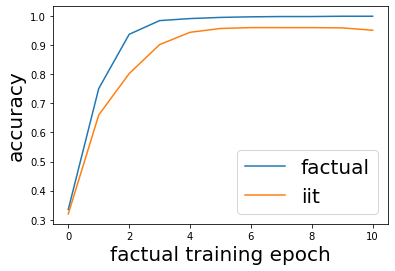

In [86]:
# Dataset
x = np.array([0,1,2,3,4,5,6,7,8,9,10])
base_f1s = np.array(base_f1s)
iit_f1s = np.array(iit_f1s)
 
# Plotting the Graph
plt.plot(x, base_f1s, label="factual")
plt.plot(x, iit_f1s, label="iit")
plt.ylabel("accuracy", fontsize=20)
plt.xlabel("factual training epoch", fontsize=20)
plt.legend(fontsize=20)
plt.show()